# Glint Data Processing Master Script

In this script each of the four versions of the glint experiment are able to be processed into a master data sheet for each experiment. 

The experiments include:
(1) Original Familiar Glint
(2) Original Novel Glint
In both of these experiments, three conditions of transformed images are presented with only one stimulus duration. 

The second set of experiments include: 
(3) Familiar Glint Extreme 
(4) Novel Glint Extreme
In these two versions, three conditions of transformed images are presented with 4 different stimulus durations. 

The distinction between familiar and novel is that familiar shows participants previously learned images, while novel presents unknown images that are learned and then tested on. 

The functions are split into two cells for the notebook for visualisation purposes, but for actual python script, they will grouped together at start of script.

I highly recommend always resetting the variables before each version.


In [32]:
#Clear previous output and variables to ensure no mixing of the data
%reset -f

In [33]:
# Import Necessary Packages 
import os
import pandas as pd
import glob
import numpy as np
import pdb


## Preprocessing Function

In [35]:
def preprocessing_pipeline(experiment_type, is_extreme):
    """Preprocess GLINT data based on experiment type and extreme flag.
    1. Sets experiment parameters.
    2. Loads data files.
    3. Loops through subjects, conditions, stimulus duration, and animacy to filter trials and calculate accuracy.
    4. Compiles results into a summary dataframe.
    
    Inputs: 
        experiment_type (str): 'novel' or 'familiar' to specify experiment version.
        is_extreme (bool): True for extreme version, False for original version.
    Returns:
        sub_summary (pd.DataFrame): Summary dataframe with accuracy and trial counts.
        settings (dict): Configuration dictionary with experiment parameters.
        experiment (str): Experiment version used.
        extreme (bool): Extreme flag used.
    """

    ''' Experiment parameters and settings (1 & 2 are inputs, 3-7 defined by the inputs or hard coded)
    1. experiment (novel or familiar)
    2. extreme flag (True for extreme version, False for original version)
    3. durations (if extreme is True) 
    4. animacies 
    5. base path for data
    6. file paths for the selected experiment version
    7. base columns for summary dataframe
    '''
    settings = {'experiment': experiment_type,'extreme': is_extreme,}
    
    experiment = settings['experiment'] #version of the experiment: familiar or novel

    extreme = settings['extreme'] # Sets extreme flag to determine if this is the extreme version of the experiment or not
    

    if extreme == True:
        durations = [0.3, 0.136, 0.068, 0.034] if extreme == True else [None] #durations only matter if extreme is True
    elif extreme == False:
        durations = [0.3] #if not extreme, duration is not applicable

    if experiment == 'familiar':
        animacies = ['anim_natural', 'inanim_natural', 'inanim_artificial']
    
    elif experiment == 'novel':
        animacies = ['inanim_artificial'] #animacies for both versions of the experiment, but we define them here for clarity and consistency in the code structure


    # Define the columns for the summary dataframe, this will be used to compile the results for each subject and condition
    base_cols = ['experiment_label', 
                'sub', #subject identifier
                'condition', #condition (natural, feature, shape)
                'stimulus_duration',#stimulus duration (only if extreme is True)
                'animacy', #animacy (only if animacy_inclusion is True)
                'un_filtered_acc', #accuracy before filtering
                'filtered_acc', #accuracy after filtering
                'no_responses', #number of no responses
                'num_trials_after_exclusion', #number of trials after all exclusions
                'num_of_outliers', #number of RT outliers
                'num_of_fast_responses', #number of fast responses (RT < 100ms)
                'total_number_of_excluded_trials'] #total number of excluded trials (no responses + fast responses + RT outliers)
    
    sub_summary = pd.DataFrame(columns=base_cols) #initialize empty dataframe with the appropriate columns, this will hold the final summary data


    #Need to differentiate the file paths based on if this is extreme or not
    base = '/zpool/vladlab/data_drive/glint_data' #base path for the data, this is the same for all versions of the experiment
    if extreme == True:
        core_path = f'{base}/{experiment}_glint_extreme' # set core path using experiment variable and base path
        print(f"You have selected {experiment} glint extreme experiment")

    elif extreme == False: 
        core_path = f'{base}/{experiment}_glint' # set core path using experiment variable and base path
        print(f"You have selected {experiment} glint experiment")


    #Now that they have selected the path for this version, it will gather all files associated with that version of the experiment    
    files = glob.glob(f'{core_path}/*.csv')  


    # Loop through each subject in this version of the experiment and process their data
    for file in files:
        print(f"\nProcessing file: {file}") #print the file being processed for tracking purposes
        try:
            predata = pd.read_csv(file) #read in the data file

        except Exception as e:
            print(f"Failed to read {file}: {e}")

            raise ValueError("No file by this name.")
        
    
        if 'participant' not in predata.columns:
            print(f"Error detected, 'participant' column missing in {file}")

            raise ValueError("Missing 'participant' column in data.") #Acts as a first layer defense to catch files that may not have the expected structure
        
        
        #Define a mapping of the data columns to standardize the column names across versions of the experiment 
        column_map = {
        "img_condition": "condition",
        "object_category": "animacy",
        "img_class": "test_object_class",
        "object_class": "test_object_class",}

        #rename the colimns to standardize across experiment versions
        data = predata.rename(columns=column_map)

        # Define a mapping for the conditions to standardize the condition names to their true names
        condition_mapping = {"natural": "natural", "scrambled": "feature", "line_drawing": "shape"}
        
        #Standardize the condition names in the data using the mapping
        data["condition"] = data["condition"].replace(condition_mapping)

        #get subject identifier from the data
        sub = data.loc[0, 'participant']
        print(f"\nProcessing Subject: {data.loc[0, 'participant']}")

        #initialize empty dataframe for this subject's conditions to hold the summary data for each loop through the conditions, stimulus durations, and animacies
        condition_summary = pd.DataFrame(columns=sub_summary.columns)
        
        # Check practice accuracy if column exists
        if 'prac_key_resp.corr' in data.columns:
            practice_trials = data['prac_key_resp.corr'].mean() #calculate practice trials accuracy
            #print(f"  Practice trials accuracy: {practice_trials:.3f}")
            if practice_trials < 0.5:
                print(f"  Caution: Low accuracy in practice trials for {data.loc[0, 'participant']} Accuracy =  {practice_trials:.3f}. Check data quality.")
            elif practice_trials >= 0.5:
                print(f"  Practice trials accuracy looks good for {data.loc[0, 'participant']}, Accuracy =  {practice_trials:.3f}")
        else:
            print(f"  Warning: 'prac_key_resp.corr' column not found in {file}")
        # Loop through each condition
        for condition in ['natural', 'feature', 'shape']:
            
            # Check for required columns
            needed = ['key_resp.corr', 'response_label','test_object_class','animacy','condition',]  #list of needed columns for processing
            if extreme == True:
                needed.append('stimulus_duration') #if extreme is True, we also need the stimulus duration column for processing
            
            if any(col not in data.columns for col in needed): 
                print(f"Missing expected columns in {file}") 
                raise ValueError("Missing expected columns in data.") #Second layer of defense to catch files that may be missing critical columns for the analysis
            
            
            # Loop through stimulus durations and animacies if applicable
            for stimulus_duration in durations: 
                
                # Nested loop for animacy if applicable
                for animacy in animacies: #loop through each animacy
                    

                    # Use trials function to import trials and filter based on current parameters
                    if extreme == False:
                        trials = data[(data['condition'] == condition) & (data['animacy'] == animacy)] #if not extreme, we don't need to filter by stimulus duration, so we only filter by condition and animacy
                    
                    elif extreme == True:
                        trials = data[(data['condition'] == condition) & (data['stimulus_duration'] == stimulus_duration) & (data['animacy'] == animacy)]
                    
                    # Check if trials is None or empty, and will raise an error if so
                    if trials is None or len(trials) == 0:
                        print(f"  No trials found for {condition}, {animacy}, {stimulus_duration}")
                        raise ValueError("No trials found.")
                    
                    # Takes only trials with a response, and counts the number of no responses
                    no_response_filter = trials[trials['response_label'] != 'no response'] #filter out no responses
                    number_of_no_responses = len(trials) - len(no_response_filter) #count number of no responses


                    '''
                    Exclusion Criteria 1: RTs less than or equal to 100ms, and counts the number of fast responses
                    Exclusion Criteria 2: RTs outside mean ± 2*SD
                    We also remove no responses first, so that we are only looking at RTs for trials where there was a response, 
                    and then we apply the RT filters to those trials. This way we can accurately count 
                    the number of no responses, fast responses, and RT outliers separately.
                    '''

                    #Filters out RTs less than or equal to 100ms, and counts the number of fast responses
                    rt_less_equal_100 = no_response_filter[no_response_filter['key_resp.rt'] >= 0.100] #filter out RTs less than or equal to 100ms
                    number_of_fast_responses = len(no_response_filter) - len(rt_less_equal_100) #count number of RTs less than or equal to 100ms
    

                    #Calculates the mean and standard deviation of RTs for trials with RTs greater than 100ms, which will be used to identify outliers based on the mean ± 2*SD criterion
                    rt_plus_minus_2sd = rt_less_equal_100['key_resp.rt'].dropna() #drop NaN values
                    mean_rt = rt_plus_minus_2sd.mean() #calculate mean RT
                    std_rt = rt_plus_minus_2sd.std(ddof=1) #calculate standard deviation of RT
    
                    #Filters out RTs outside mean ± 2*SD, and counts the number of RT outliers
                    final_trials = rt_less_equal_100[rt_less_equal_100['key_resp.rt'].between(mean_rt - 2*std_rt, mean_rt + 2*std_rt)] #filter out RTs outside mean ± 2*SD

                    number_of_outliers = len(rt_less_equal_100) - len(final_trials) #count number of RT outliers
                        

                    # Calculate the variables of interest and compile into a row for condition summary
                    acc = trials['key_resp.corr'].mean() #accuracy before filtering
                    filtered_acc = final_trials['key_resp.corr'].mean() #accuracy after filtering   
                    trial_count = len(final_trials) #number of trials after all exclusions


                    #Combines the experiment and extreme parameters into a single label for the summary dataframe
                    extreme_label = 'extreme' if extreme else 'original' #create label for extreme status

                    experiment_label = f"{experiment}_{extreme_label}"  #combine experiment and extreme status into a single label for the summary dataframe    

                    #sums up the total number of trials for this condition, stimulus duration, and animacy that were excluded based on the filters applied
                    number_of_excluded_trials = number_of_no_responses + number_of_fast_responses + number_of_outliers 

                    #Compiles all the variables of interest into a row for the condition summary dataframe
                    row = {
                        'experiment_label': experiment_label, #experiment and extreme status
                        'sub': sub, #subject identifier
                        'condition': condition, #condition (natural, scrambled, line_drawing)
                        'stimulus_duration': stimulus_duration, #stimulus duration (only if extreme is True)
                        'animacy': animacy, #animacy (only if animacy_inclusion is True)
                        'un_filtered_acc': acc, #accuracy before filtering
                        'filtered_acc': filtered_acc, #accuracy after filtering
                        'no_responses': number_of_no_responses, #number of no responses
                        'num_trials_after_exclusion': trial_count, #number of trials after all exclusions
                        'num_of_outliers': number_of_outliers, #number of RT outliers
                        'num_of_fast_responses': number_of_fast_responses, #number of fast responses (RT < 100ms)
                        'total_number_of_excluded_trials': number_of_excluded_trials, #total number of excluded trials
                    }

                    # Add the row to the condition summary
                    condition_summary = pd.concat([condition_summary, pd.DataFrame([row])], ignore_index=True) #append the row to the condition summary

        # After processing all conditions for this subject, append to the overall sub_summary
        sub_summary = pd.concat([sub_summary, condition_summary], ignore_index=True) #append the condition summary to the overall sub_summary


    return sub_summary, experiment, extreme  # return config so downstream steps use the same values

## Exclusion Functions

In [36]:
'''
Exclusion Criteria Functions
Here we define the functions needed to do participant exclusion.
Our exclusion criteria are:
1. Participants with accuracy in the natural condition below chance level (calculated based on the number of response options for each experiment version).
2. Participants with accuracy in the natural condition below mean - 2*SD of the natural condition accuracies across all subjects.

Functions:
1. chance_calculator: Calculates the chance level based on the experiment version and extreme flag.
Inputs: experiment version (novel or familiar) and extreme flag (True or False)
Outputs: chance level (float)

2. exclusion_check: Identifies subjects to exclude based on the two criteria and prints the results
Inputs: sub_summary dataframe and chance level
Outputs: DataFrame of flagged subjects for exclusion

3. remove_flagged_subjects: Removes the flagged subjects from the sub_summary dataframe and returns the cleaned dataframe.
Inputs: sub_summary dataframe, flagged subjects dataframe, delete flag (True to remove, False to keep for review)
Outputs: cleaned sub_summary dataframe after removing flagged subjects (if delete=True), otherwise returns original sub_summary for review.

4. create_wide_format: Creates a wide-format version of the cleaned dataframe for downstream analyses.
Inputs: cleaned sub_summary dataframe
Outputs: cleaned long-format dataframe, cleaned wide-format dataframe, and saves both to CSV files with appropriate naming based on the experiment version and extreme flag.

5. plot_summary: Quick visualization function to plot the summary data for a quick check of the results after preprocessing.
'''

def chance_calculator(experiment, extreme):
    """Return the number of response options for the given experiment/extreme combo."""
    mapping = {
        ('novel', False): 4,
        ('novel', True): 4,
        ('familiar', True): 6,
        ('familiar', False): 9,
    }

    number_of_choices = mapping.get((experiment, extreme))

    chance = 1 / number_of_choices #formula for calculating chance 
    print(f"Calculated chance level based on {number_of_choices} choices: {chance:.3f}")
    return chance

def exclusion_check(sub_summary,chance):
    """Returns per_sub DataFrame with natural condition accuracies per subject."""
    
    natural_acc = sub_summary[sub_summary['condition'] == 'natural'] # Filters for the condition of natural, and calculates the mean
    
    if natural_acc.empty:
        print("No 'natural' rows found in `sub_summary`.")
        # Return empty DataFrame with expected columns to avoid UnboundLocalError
        raise ValueError("No 'natural' rows found in sub_summary; cannot compute exclusion criteria.")
    
    per_sub = (
        natural_acc.groupby('sub', as_index=False)['filtered_acc']
        .mean()
        .rename(columns={'filtered_acc': 'natural_filtered_acc'})
    )

    """Calculate threshold for exclusion based on mean - 2*SD of natural accuracies."""
    mean_nat = per_sub['natural_filtered_acc'].mean() #calculate mean of natural filtered accuracy
    sd_nat = per_sub['natural_filtered_acc'].std(ddof=1) #calculate standard deviation of natural filtered accuracy
    thresh = mean_nat - 2 * sd_nat #calculate threshold as mean - 2*SD
    print(f"Natural condition: mean = {mean_nat:.3f}, sd = {sd_nat:.3f}, threshold (mean - 2sd) = {thresh:.3f}") #print threshold values
    
    ''' Flag subjects below chance level and below 2SD threshold, and print results.'''
    flagged_below_chance = per_sub[per_sub['natural_filtered_acc'] <= chance].copy() #flag subjects below chance level
    
    print(f"Chance threshold = {chance:.3f}") 
    
    print(f"Found {len(flagged_below_chance)} subject(s) below chance:") 
    
    if not flagged_below_chance.empty: 
        
        print(flagged_below_chance.sort_values('natural_filtered_acc')) #print flagged subjects below chance level
    

    flagged = per_sub[per_sub['natural_filtered_acc'] <= thresh].copy() #flag subjects below 2SD threshold
    
    print(f"Threshold for exclusion (mean - 2sd) = {thresh:.3f}")
    
    print(f"Found {len(flagged)} subject(s) below or equal to threshold:")
    
    if not flagged.empty:
        
        print(flagged.sort_values('natural_filtered_acc'))
    
    # Combine with flagged_below_chance if any
    if not flagged_below_chance.empty:
        
        flagged = pd.concat([flagged, flagged_below_chance], ignore_index=True).drop_duplicates()  #combine flagged subjects below chance with those below 2SD threshold
        
        print("Subjects below chance combined with subjects below 2SD threshold.")
    
    if flagged.empty:
        print("No subjects are below (or equal to) mean - 2*SD for natural filtered accuracy.")

    else:
        print(f"Flagged {len(flagged)} subject(s) total for exclusion:")

        print(flagged.sort_values('natural_filtered_acc'))
    
    return flagged 

def remove_flagged_subjects(sub_summary, flagged, delete=True):
    if flagged.empty:

        print("No subjects to remove based on exclusion criteria.")

        return sub_summary.copy() #return original sub_summary if no flagged subjects
    
    flagged_df = flagged.copy() #make a copy of flagged subjects DataFrame

    print(f"Flagged subjects to remove ({len(flagged_df)}):")

    print(flagged_df.sort_values('natural_filtered_acc'))
    
    flagged_subs = set(flagged_df['sub']) #get unique subject identifiers from flagged subjects

    n_rows_before = len(sub_summary) #count number of rows before removal

    n_rows_removed = sub_summary['sub'].isin(flagged_subs).sum() #count number of rows to be removed
    print(f"Preview: {n_rows_removed} rows (of {n_rows_before}) belong to flagged subject(s).") 
    
    if delete:

        cleaned = sub_summary[~sub_summary['sub'].isin(flagged_subs)].copy() #remove flagged subjects from sub_summary
        print(f"Removed {n_rows_removed} rows.")
    else:
        cleaned = sub_summary.copy() #keep original sub_summary if delete is False
        print("Delete=False: Keeping all rows in cleaned dataset.")
    
    return cleaned


def create_wide_df_save(cleaned, experiment, extreme, output_path):
    cleaned_wide = None
    
    #I kept running into errors when trying to create the wide format, so I wrapped it in a try except block to catch any errors and print them out
    try:
        values = ['un_filtered_acc', 'filtered_acc', 'no_responses', 'num_trials_after_exclusion'] #values to pivot on

        pivot_df = cleaned.pivot(index='sub', columns=['condition', 'stimulus_duration', 'animacy'], values=values) #pivot table with condition, stimulus_duration, and animacy as columns
        
        new_cols = [] #new column names list


        for col in pivot_df.columns: #loop through the columns in the pivoted dataframe to format the column names

            if len(col) == 3:
                metric, condition, duration = col #unpack the column tuple into metric, condition, and duration

                new_cols.append(f"{condition}_{duration}_{metric}") #format new column names

            else:
                new_cols.append("_".join([str(c) for c in col])) #join other columns as strings

        pivot_df.columns = new_cols #assign new column names to the pivoted dataframe

        pivot_df.reset_index(inplace=True) #reset index to make 'sub' a column again

        cleaned_wide = pivot_df #assign pivoted DataFrame to cleaned_wide

    except Exception as e:

        cleaned_wide = None #assign None to cleaned_wide if there was an error during pivoting

        print(f"Could not create wide-format: {e}") #alerts you if there was an error in pivoting data

    #Create a name for the final csv files based on the experiment version and extreme flag
    version = 'extreme' if extreme else 'original' #determine version based on extreme status

    final_csv = f'{experiment}_glint_{version}_cleaned.csv' #construct final CSV filename

    #Save the cleaned long-format
    cleaned.to_csv(os.path.join(output_path, final_csv), index=False) #save long-format DataFrame to CSV

    print(f"Final cleaned sub_summary saved to {os.path.join(output_path, final_csv)}") 

    # Save the wide-format DataFrame to CSV, if it was successfully created
    if cleaned_wide is not None:

        cleaned_wide.to_csv(os.path.join(output_path, f'{experiment}_glint_{version}_cleaned_wide.csv'), index=False) #save wide-format DataFrame to CSV

        print(f"Final cleaned wide-format sub_summary saved to {os.path.join(output_path, f'{experiment}_glint_{version}_cleaned_wide.csv')}")

    return cleaned, cleaned_wide

# Quick Visualization
def plot_summary(data, extreme,chance):
    import seaborn as sns
    import matplotlib.pyplot as plt

    fig, ax1 = plt.subplots(figsize=(8, 5))
    if extreme == False:
        sns.barplot(
            data=data,
            x="condition",
            y="filtered_acc",
            ax = ax1,
            capsize=0.3,
            errorbar=("ci", 95),
            palette="magma",
            zorder=2,
            hue="condition"
        )
    elif extreme == True:
        sns.pointplot(
            data=data,
            x="stimulus_duration",
            y="filtered_acc",
            hue="condition",
            palette="magma",
            order=[0.3, 0.136, 0.068, 0.034],
            capsize=0.2,
            errorbar= ("ci", 95)
        )
    
    ax1.set_ylim(0.1, 1.0)
    ax1.set_ylabel('Accuracy')
    ax1.set_xlabel('Condition')
    ax1.axhline(y=chance, color='black', linestyle='--', linewidth=1.5, zorder=11)
    return plt.gca()


# Run the Preprocessing and Exclusion Functions
Experiment 1: Familiar Original

Experiment 2: Familiar Extreme

Experiment 3: Novel Orginal

Experiment 4: Novel Extreme

## Familiar Original

In [5]:
#Run the preprocessing pipeline for familiar Original version, experiment = 'familiar' and extreme = False
sub_summary, experiment, extreme = preprocessing_pipeline('familiar', False)


You have selected familiar glint experiment

Processing Subject: 6678813aec86d687a654dedb
  Practice trials accuracy looks good for 6678813aec86d687a654dedb, Accuracy =  1.000

Processing Subject: 5db0e17518230d00170d4332
  Practice trials accuracy looks good for 5db0e17518230d00170d4332, Accuracy =  1.000

Processing Subject: 5aa2dcf36219a30001f57b7e
  Practice trials accuracy looks good for 5aa2dcf36219a30001f57b7e, Accuracy =  1.000

Processing Subject: 67819f666062825529fe313e
  Practice trials accuracy looks good for 67819f666062825529fe313e, Accuracy =  1.000

Processing Subject: 67e85a8becc5f7048616c4be
  Practice trials accuracy looks good for 67e85a8becc5f7048616c4be, Accuracy =  0.800

Processing Subject: 617323e630f3fa36361cb35b
  Practice trials accuracy looks good for 617323e630f3fa36361cb35b, Accuracy =  0.800

Processing Subject: 5fd66ce8aec66457ff73d743
  Practice trials accuracy looks good for 5fd66ce8aec66457ff73d743, Accuracy =  1.000

Processing Subject: 5b53e95f4bb

Calculated chance level based on 9 choices: 0.111
Running Exclusion check for experiment = familiar, extreme = False, chance level = 0.111
Natural condition: mean = 0.952, sd = 0.108, threshold (mean - 2sd) = 0.736
Chance threshold = 0.111
Found 0 subject(s) below chance:
Threshold for exclusion (mean - 2sd) = 0.736
Found 2 subject(s) below or equal to threshold:
                         sub  natural_filtered_acc
34  66afcaa60f7d8f58dc21db8e              0.321637
37  66cec5a3fdf1fe2c010e9971              0.639163
Flagged 2 subject(s) total for exclusion:
                         sub  natural_filtered_acc
34  66afcaa60f7d8f58dc21db8e              0.321637
37  66cec5a3fdf1fe2c010e9971              0.639163
Flagged subjects to remove (2):
                         sub  natural_filtered_acc
34  66afcaa60f7d8f58dc21db8e              0.321637
37  66cec5a3fdf1fe2c010e9971              0.639163
Preview: 18 rows (of 468) belong to flagged subject(s).
Removed 18 rows.
Final cleaned sub_summary sa

<Axes: xlabel='Condition', ylabel='Accuracy'>

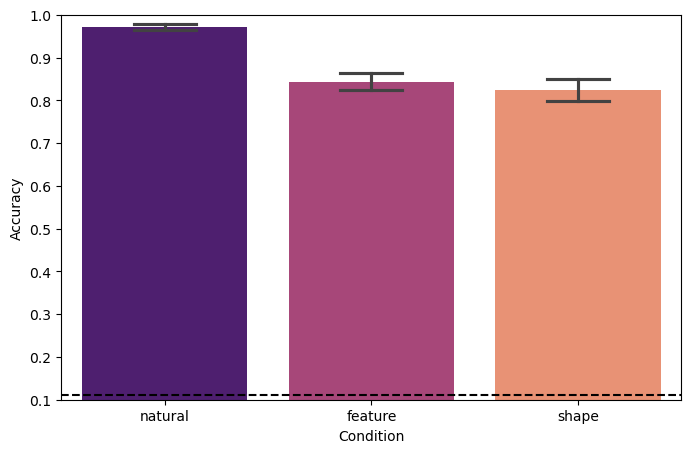

In [6]:
#Run the Exclusion Check, remove the flagged subjects, create the wide format, and save the cleaned dataframes to CSV files for the familiar original version, experiment = 'familiar' and extreme = False

chance = chance_calculator(experiment, extreme)
print(f"Running Exclusion check for experiment = {experiment}, extreme = {extreme}, chance level = {chance:.3f}")

flagged = exclusion_check(sub_summary,chance) #Flag subjects based on exclusion criteria

sub_summary_cleaned = remove_flagged_subjects(sub_summary, 
                                              flagged, 
                                              delete=True) # Remove flagged subjects

familiar_original_long_df, familiar_original_wide_df = create_wide_df_save(sub_summary_cleaned,
                                                                        experiment,
                                                                        extreme, 
                                                                        output_path = '/zpool/vladlab/data_drive/glint_data/summary_data_csv/') # Create wide format



plot_summary(familiar_original_long_df, extreme,chance)


## Familiar Extreme

In [37]:
#Run the preprocessing pipeline for familiar Extreme version, experiment = 'familiar' and extreme = True
sub_summary, experiment, extreme = preprocessing_pipeline('familiar', True)


You have selected familiar glint extreme experiment

Processing file: /zpool/vladlab/data_drive/glint_data/familiar_glint_extreme/667ef3c6b1ce7f18e774b31b_familiar_glint_extreme_2025-12-10_13h19.52.829.csv

Processing Subject: 667ef3c6b1ce7f18e774b31b
  Practice trials accuracy looks good for 667ef3c6b1ce7f18e774b31b, Accuracy =  1.000

Processing file: /zpool/vladlab/data_drive/glint_data/familiar_glint_extreme/663a8c84b8e7c046d854c8dd_familiar_glint_extreme_2025-12-10_12h56.43.428.csv

Processing Subject: 663a8c84b8e7c046d854c8dd
  Practice trials accuracy looks good for 663a8c84b8e7c046d854c8dd, Accuracy =  0.800

Processing file: /zpool/vladlab/data_drive/glint_data/familiar_glint_extreme/6643c412ed568375e3bf349c_familiar_glint_extreme_2025-12-10_12h41.35.449.csv

Processing Subject: 6643c412ed568375e3bf349c
  Practice trials accuracy looks good for 6643c412ed568375e3bf349c, Accuracy =  0.800

Processing file: /zpool/vladlab/data_drive/glint_data/familiar_glint_extreme/672268205351

Calculated chance level based on 6 choices: 0.167
Running Exclusion check for experiment = familiar, extreme = True, chance level = 0.167
Natural condition: mean = 0.836, sd = 0.098, threshold (mean - 2sd) = 0.640
Chance threshold = 0.167
Found 0 subject(s) below chance:
Threshold for exclusion (mean - 2sd) = 0.640
Found 3 subject(s) below or equal to threshold:
                         sub  natural_filtered_acc
43  6745f73ee7541460adbabcff              0.555556
25  6628f4e77ba6d4332996845e              0.612500
49  67aa80c774c81448a3876d15              0.638889
Flagged 3 subject(s) total for exclusion:
                         sub  natural_filtered_acc
43  6745f73ee7541460adbabcff              0.555556
25  6628f4e77ba6d4332996845e              0.612500
49  67aa80c774c81448a3876d15              0.638889
Flagged subjects to remove (3):
                         sub  natural_filtered_acc
43  6745f73ee7541460adbabcff              0.555556
25  6628f4e77ba6d4332996845e              0.612500


<Axes: xlabel='Condition', ylabel='Accuracy'>

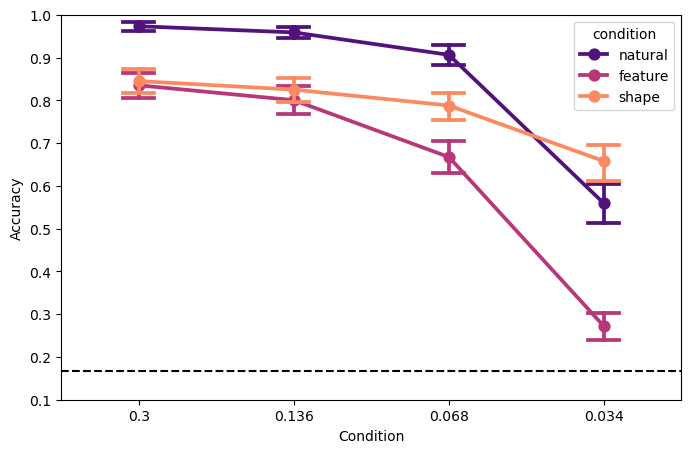

In [38]:
#Run the Exclusion Check, remove the flagged subjects, create the wide format, and save the cleaned dataframes to CSV files for the familiar extreme version, experiment = 'familiar' and extreme = True

chance = chance_calculator(experiment, extreme)
print(f"Running Exclusion check for experiment = {experiment}, extreme = {extreme}, chance level = {chance:.3f}")

flagged = exclusion_check(sub_summary,chance) #Flag subjects based on exclusion criteria

sub_summary_cleaned = remove_flagged_subjects(sub_summary, 
                                              flagged, 
                                              delete=True) # Remove flagged subjects

familiar_extreme_long_df, familiar_extreme_wide_df = create_wide_df_save(sub_summary_cleaned,
                                                                        experiment,
                                                                        extreme, 
                                                                        output_path = '/zpool/vladlab/data_drive/glint_data/summary_data_csv/') # Create wide format



plot_summary(familiar_extreme_long_df, extreme,chance)


## Novel Original

In [16]:
#Run the preprocessing pipeline for Novel Original version, experiment = 'novel' and extreme = False
sub_summary, experiment, extreme = preprocessing_pipeline('novel', False)

You have selected novel glint experiment

Processing Subject: 66293da691cec8862619b1dc
  Practice trials accuracy looks good for 66293da691cec8862619b1dc, Accuracy =  0.750

Processing Subject: 62713a003caa3feec5c6a0ba
  Practice trials accuracy looks good for 62713a003caa3feec5c6a0ba, Accuracy =  1.000

Processing Subject: 661ae93e33b51f5d31a8c3bb
  Practice trials accuracy looks good for 661ae93e33b51f5d31a8c3bb, Accuracy =  0.938

Processing Subject: 6671c66b6e4bc111961291ae
  Practice trials accuracy looks good for 6671c66b6e4bc111961291ae, Accuracy =  1.000

Processing Subject: 680dcb74ab0a3a21ef2d6d89
  Caution: Low accuracy in practice trials for 680dcb74ab0a3a21ef2d6d89 Accuracy =  0.438. Check data quality.

Processing Subject: 662fecef2a008847dc4f0d9b
  Practice trials accuracy looks good for 662fecef2a008847dc4f0d9b, Accuracy =  0.938

Processing Subject: 5e836a3c2598d409928dae31
  Practice trials accuracy looks good for 5e836a3c2598d409928dae31, Accuracy =  1.000

Processin

Calculated chance level based on 4 choices: 0.250
Running Exclusion check for experiment = novel, extreme = False, chance level = 0.250
Natural condition: mean = 0.671, sd = 0.247, threshold (mean - 2sd) = 0.176
Chance threshold = 0.250
Found 3 subject(s) below chance:
                         sub  natural_filtered_acc
37  66a398080da27efcc3e8ecef              0.142857
43  670efd496f9f47e38a4b1d7d              0.216216
5   5aed18cf026e1300018199b3              0.230769
Threshold for exclusion (mean - 2sd) = 0.176
Found 1 subject(s) below or equal to threshold:
                         sub  natural_filtered_acc
37  66a398080da27efcc3e8ecef              0.142857
Subjects below chance combined with subjects below 2SD threshold.
Flagged 3 subject(s) total for exclusion:
                        sub  natural_filtered_acc
0  66a398080da27efcc3e8ecef              0.142857
3  670efd496f9f47e38a4b1d7d              0.216216
1  5aed18cf026e1300018199b3              0.230769
Flagged subjects to rem

<Axes: xlabel='Condition', ylabel='Accuracy'>

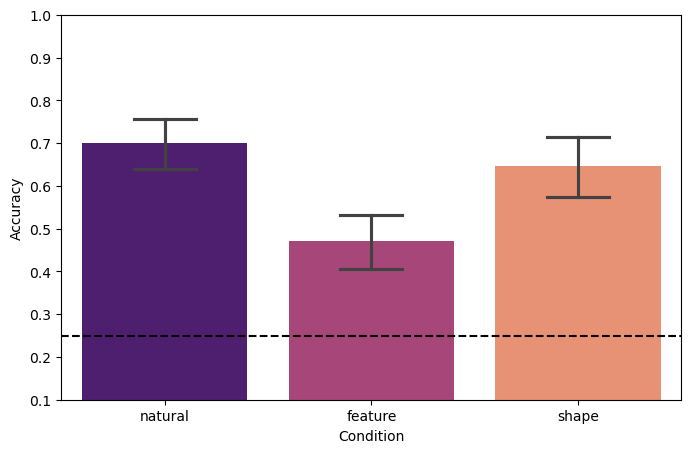

In [17]:
#Run the Exclusion Check, remove the flagged subjects, create the wide format, and save the cleaned dataframes to CSV files for the novel original version, experiment = 'novel' and extreme = False

chance = chance_calculator(experiment, extreme)
print(f"Running Exclusion check for experiment = {experiment}, extreme = {extreme}, chance level = {chance:.3f}")

flagged = exclusion_check(sub_summary,chance) #Flag subjects based on exclusion criteria

sub_summary_cleaned = remove_flagged_subjects(sub_summary, 
                                              flagged, 
                                              delete=True) # Remove flagged subjects

novel_original_long_df, novel_original_wide_df = create_wide_df_save(sub_summary_cleaned,
                                                                        experiment,
                                                                        extreme, 
                                                                        output_path = '/zpool/vladlab/data_drive/glint_data/summary_data_csv/') # Create wide format



plot_summary(novel_original_long_df, extreme, chance)


## Novel Extreme

In [22]:
#Run the preprocessing pipeline for Novel Extreme version, experiment = 'novel' and extreme = True
sub_summary, experiment, extreme = preprocessing_pipeline('novel', True)

You have selected novel glint extreme experiment

Processing Subject: 63d176dbaef5e7827cd86954
  Practice trials accuracy looks good for 63d176dbaef5e7827cd86954, Accuracy =  1.000

Processing Subject: 66d0217be06f8783cc04f0a7
  Practice trials accuracy looks good for 66d0217be06f8783cc04f0a7, Accuracy =  1.000

Processing Subject: 614eb489b0a5f38772bab599
  Practice trials accuracy looks good for 614eb489b0a5f38772bab599, Accuracy =  1.000

Processing Subject: 67677ba17f0a93a3a60ff516
  Practice trials accuracy looks good for 67677ba17f0a93a3a60ff516, Accuracy =  0.688

Processing Subject: 6706bc0d8c98b64939838b2e
  Practice trials accuracy looks good for 6706bc0d8c98b64939838b2e, Accuracy =  0.875

Processing Subject: 60ba9b1108f554e36941c2b4
  Practice trials accuracy looks good for 60ba9b1108f554e36941c2b4, Accuracy =  0.875

Processing Subject: 63a9a8f2f098b7e45bd03721
  Practice trials accuracy looks good for 63a9a8f2f098b7e45bd03721, Accuracy =  1.000

Processing Subject: 6643a2

Calculated chance level based on 4 choices: 0.250
Running Exclusion check for experiment = novel, extreme = True, chance level = 0.250
Natural condition: mean = 0.585, sd = 0.185, threshold (mean - 2sd) = 0.215
Chance threshold = 0.250
Found 0 subject(s) below chance:
Threshold for exclusion (mean - 2sd) = 0.215
Found 0 subject(s) below or equal to threshold:
No subjects are below (or equal to) mean - 2*SD for natural filtered accuracy.
No subjects to remove based on exclusion criteria.
Final cleaned sub_summary saved to /zpool/vladlab/data_drive/glint_data/summary_data_csv/novel_glint_extreme_cleaned.csv
Final cleaned wide-format sub_summary saved to /zpool/vladlab/data_drive/glint_data/summary_data_csv/novel_glint_extreme_cleaned_wide.csv


<Axes: xlabel='Condition', ylabel='Accuracy'>

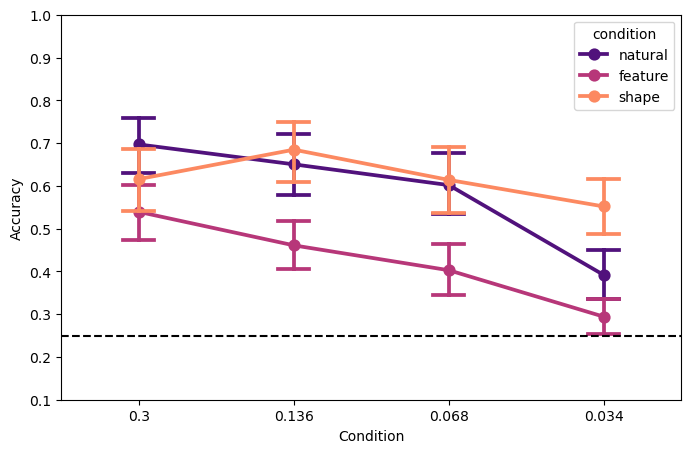

In [23]:
#Run the Exclusion Check, remove the flagged subjects, create the wide format, and save the cleaned dataframes to CSV files for the Novel extreme version, experiment = 'novel' and extreme = True

chance = chance_calculator(experiment, extreme)
print(f"Running Exclusion check for experiment = {experiment}, extreme = {extreme}, chance level = {chance:.3f}")

flagged = exclusion_check(sub_summary,chance) #Flag subjects based on exclusion criteria

sub_summary_cleaned = remove_flagged_subjects(sub_summary, 
                                              flagged, 
                                              delete=True) # Remove flagged subjects

novel_extreme_long_df, novel_extreme_wide_df = create_wide_df_save(sub_summary_cleaned,
                                                                        experiment,
                                                                        extreme, 
                                                                        output_path = '/zpool/vladlab/data_drive/glint_data/summary_data_csv/') # Create wide format



plot_summary(novel_extreme_long_df, extreme,chance)
